# Kaggle Dogs vs Cats Library and Demo

This is a library to download and parse the [Kaggle's Dogs vs Cats competition](https://www.kaggle.com/competitions/dogs-vs-cats/overview) dataset and a demo of CNNs.

It's inspired on [Keras' Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/) demo.

## Environment Set Up

Let's set up `go.mod` to use the local copy of GoMLX, so it can be developed jointly the dataset code with the model. That's often how data pre-processing and model code is developed together with experimentation.

If you are not changing code, feel free to simply skip this cell. Or if you used a different directory for you projects, change it below.

Notice the directory `${HOME}/Projects/gomlx` is where the GoMLX code is copied by default in [its Docker](https://hub.docker.com/repository/docker/janpfeifer/gomlx_jupyterlab/general).

In [1]:
!*go mod edit -replace github.com/gomlx/gomlx="${HOME}/Projects/gomlx"

## Data Preparation

The dataset takes ~790Mb compressed, and contains ~25K examples (a few are not parseable JPG), evenly split. We further separate this into 20K for training and 5K for validation/testing, randomly picked. 

GoMLX provides a dataset loading and data augmentation [library for the Kaggle Dogs vs Cats competition](https://pkg.go.dev/github.com/gomlx/gomlx@v0.1.0/examples/dogsvscats#section-readme). 
This make it easy to acess the data -- but this notebook serves as documentation and example for the library.

Let's first create the train/validation dataset, and display a sample of the augmented images. The `dogsvscats` library provide a `dogsvscats.CreateDatasets`
function that takes a `dogsvscats.Configuration` and returns 3 datasets: one for training; one for evaluation on training data; one for evaluation on a validation (separate) data. Only the training data is augmented, and we use that in the cell below to sample from -- you'll notice some random rotations, and images are randomly flipped.

The first time it runs it may take a while, since it needs to download the data from the internet. The default directory for the data is `${HOME}/tmp/dogs_vs_cats/`, but you can change it, by setting the `--data` flag. The next time it runs it will re-use the downloaded data.

Dog,Dog,Dog,Dog
Cat,Cat,Cat,Cat

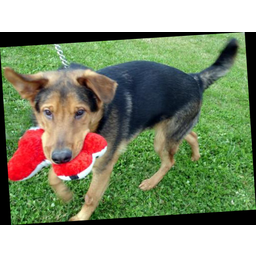
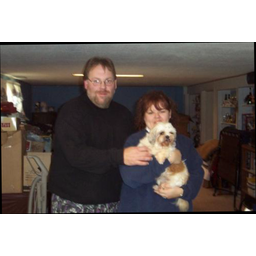
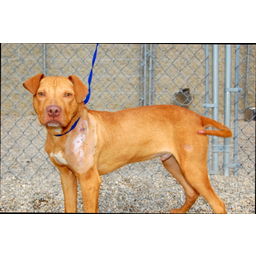
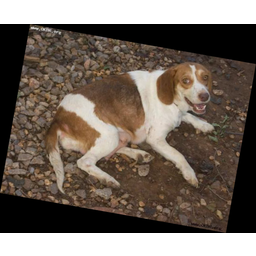
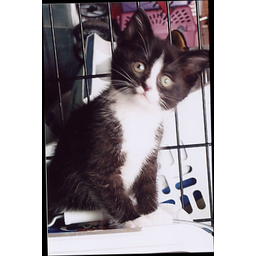
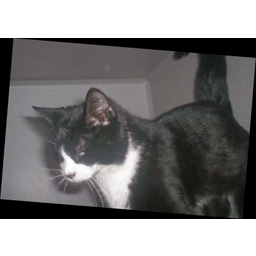
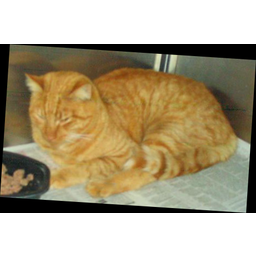
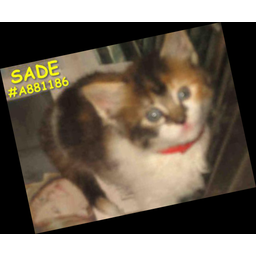

In [2]:
import (
    "github.com/gomlx/gomlx/examples/dogsvscats"
    "github.com/gomlx/gomlx/types/tensor"
    "github.com/gomlx/gomlx/ml/data"

    "github.com/janpfeifer/gonb/gonbui"
)

var (
    flagDataDir   = flag.String("data", "~/work/dogs_vs_cats", "Directory to cache downloaded and generated dataset files.")
    flagBatchSize = flag.Int("batch", dogsvscats.DefaultConfig.BatchSize, "Batch size for training")

    flagAugment      = flag.Bool("augment", true, "Whether to augment the data during training or sampling. Evaluation is never augmented.")
    flagAngleStdDev  = flag.Float64("angle", 5.0, "Standard deviation of noise used to rotate the image. Disabled if --augment=false.")
    flagFlipRandomly = flag.Bool("flip", true, "Randomly flip the image horizontally. Disabled if --augment=false.")
)

// AssertNoError `log.Fatal` if err is not nil.
func AssertNoError(err error) {
    if err != nil {
        log.Fatalf("Failed: %+v", err)
    }
}

// buildConfig uses flags to build configurations object.
func buildConfig() (config *dogsvscats.Configuration) {
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    if !data.FileExists(*flagDataDir) {
        AssertNoError(os.MkdirAll(*flagDataDir, 0777))
    }

    config = &dogsvscats.Configuration{}
    *config = *dogsvscats.DefaultConfig
    config.DataDir = *flagDataDir
    if !*flagAugment {
        *flagAngleStdDev = 0  // Disable angle augmentation.
        *flagFlipRandomly = false  // Disable random flipping
    }
    config.AngleStdDev = *flagAngleStdDev
    config.FlipRandomly = *flagFlipRandomly
    config.BatchSize = *flagBatchSize
    return
}

// sample some random augmented images and display them in the Notebook.
func sample(config *dogsvscats.Configuration) {
    numPerRow := 4

    var images []image.Image
    var labels []dogsvscats.DorOrCat
    var err error

    // Create datasets with batch size equals 2*numPerRow.
    var configForSample dogsvscats.Configuration
    configForSample = *config
    configForSample.BatchSize = 2*numPerRow
    configForSample.ModelImageSize = 256
    configForSample.ForceOriginal = true

    ds, _, _ := dogsvscats.CreateDatasets(&configForSample)
    _, inputs, labelsTensors, err := ds.Yield()
    AssertNoError(err)
    labelsValues := tensor.ValueOf[[]float32](labelsTensors[0].Local())
    images = make([]image.Image, 0, 2*numPerRow)
    labels = make([]dogsvscats.DorOrCat, 0, 2*numPerRow)
    for ii := 0; ii < 8; ii++ {
        images = append(images, dogsvscats.TensorToGoImage(&configForSample, inputs[0], ii))
        labels = append(labels, dogsvscats.DorOrCat(labelsValues[ii]))
    }

    htmlRows := make([]string, 0, 2)
    count := 0
    for row := 0; row < 2; row++ {
        cells := make([]string, 0, numPerRow)
        for col := 0; col < numPerRow; col++ {
            cells = append(cells, embedImageInHTML(images[count], labels[count].String()))
            count++
        }
        htmlRows = append(htmlRows, fmt.Sprintf("<tr>\n\t<td>%s</td>\n</tr>", strings.Join(cells, "</td>\n\t<td>")))
    }
    htmlTable := fmt.Sprintf("<h3>%s</h3><table>%s</table>\n", "Sample Dogs vs Cats", strings.Join(htmlRows, ""))
    gonbui.DisplayHTML(htmlTable)
}

// embedImageInHTML, with a label.
func embedImageInHTML(img image.Image, label string) string {
    imgSrc, err := gonbui.EmbedImageAsPNGSrc(img)   // Generate image in-html (in the src filed), as opposed to a separate file.
    AssertNoError(err)
    return fmt.Sprintf(`<figure style="padding:4px;text-align: center; background-color: lightgray; color: black;"><img src="%s" width="256px" height="256px"><figcaption style="text-align: center;">%s</figcaption></figure>`, imgSrc, label)
}

%%
config := buildConfig()
dogsvscats.Download(config.DataDir)
dogsvscats.FilterValidImages(config.DataDir)  // Dataset comes with some invalid images, they are removed here.
sample(config)

## Training a CNN model

Our model is a simple CNN model currently using images scaled down to 64x64 pixels, with random rotations (mean 0 and standard deviation of 5 degrees) and random flips.

### Model Definition

Let's build the model function, and check that we get the right shape in the output.

We use normalization since it speeds up (and improves) the training. Notice the normalization axes are different when normalizing for images or flat features.

In [3]:
import (
    "flag"
    "fmt"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/types/shapes"
    "github.com/gomlx/gomlx/types/slices"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/layers"
)

var (
    // ML Manager creation:
    flagNumThreads  = flag.Int("num_threads", -1, "Number of threads. Leave as -1 to use as many as there are cores.")
    flagNumReplicas = flag.Int("num_replicas", 1, "Number of replicas.")
    flagPlatform    = flag.String("platform", "", "Platform to use, if empty uses the default one.")

    // Training hyperparameters:
    flagOptimizer        = flag.String("optimizer", "adamw", fmt.Sprintf("Optimizer, options: %q", slices.SortedKeys(optimizers.KnownOptimizers)))
    flagLearningRate     = flag.Float64("learning_rate", 0.0001, "Initial learning rate.")
    flagL2Regularization = flag.Float64("l2_reg", 0, "L2 regularization on kernels. It doesn't interact well with --batch_norm.")

    // Flat part of model, after convolutions and models being flattened:
    flagNormalization    = flag.String("norm", "layer", fmt.Sprintf("Type of layer normalization to use. Valid values: %q.", slices.SortedKeys(layers.KnownNormalizers)))
    flagNumConvolutions = flag.Int("num_convolutions", 5, "Number of convolutions -- there will be at least as many to reduce the image to 16x16")
    flagNumHiddenLayers = flag.Int("hidden_layers", 3, "Number of hidden layers, stacked with residual connection.")
    flagNumNodes        = flag.Int("num_nodes", 128, "Number of nodes in hidden layers.")
)

func normalizeImage(ctx *context.Context, x *Node) *Node {
    x.AssertRank(4)  // [batch_size, width, height, depth]
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, 1, 2).ScaleNormalization(false).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    log.Fatalf("Invalid --norm=%q, value not supported.", *flagNormalization)
    g := x.Graph()
    g.SetErrorf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return g.InvalidNode()
}

func normalizeFeatures(ctx *context.Context, x *Node) *Node {
    x.AssertRank(2)  // [batch_size, embedding_dim]
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, -1).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    log.Fatalf("Invalid --norm=%q, value not supported.", *flagNormalization)
    g := x.Graph()
    g.SetErrorf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return g.InvalidNode()
}


// ModelGraph builds the model for our demo. It returns the logits, not the predictions, which works with most losses.
// inputs: only one tensor, with shape `[batch_size, width, height, depth]`.
func ModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    _ = spec // Not needed.
    x := inputs[0]
    g := x.Graph()
    const filterSize = 32
    batchSize := x.Shape().Dimensions[0]
    logits := x
    imgSize := x.Shape().Dimensions[1]
    for convIdx := 0; convIdx < *flagNumConvolutions || imgSize > 16; convIdx++ {
        ctx := ctx.In(fmt.Sprintf("conv_%d", convIdx))
        residual := logits
        if convIdx > 0 {
            logits = layers.Relu(logits)
        }
        logits = layers.Convolution(ctx, logits).Filters(filterSize).KernelSize(3).PadSame().Done()
        logits = layers.Relu(logits)
        logits = normalizeImage(ctx, logits)
        if convIdx > 0 {
            logits = Add(logits, residual)
        }
        if imgSize > 16 {
            // Reduce image size by 2 each time.
            logits = MaxPool(logits).Window(2).Done()
            imgSize /= 2
        }
        logits.AssertDims(batchSize, imgSize, imgSize, filterSize)
        AssertNoError(g.Error())
    }

    // Flatten resulting image, and treat the convolved logits as tabular.
    logits = Reshape(logits, batchSize, -1)
    for ii := 0; ii < *flagNumHiddenLayers; ii++ {
        ctx := ctx.In(fmt.Sprintf("dense_%d", ii))
        residual := logits
        // Add layer with residual connection.
        logits = layers.Relu(logits)
        logits = layers.DenseWithBias(ctx, logits, *flagNumNodes)
        logits = normalizeFeatures(ctx, logits)
        if ii >= 1 {
            logits = Add(logits, residual)
        }
        AssertNoError(g.Error())
    }
    logits = layers.Relu(logits)
    logits = layers.DenseWithBias(ctx.In("readout"), logits, 1)
    return []*Node{logits}
}

%%
config := buildConfig()
manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()

// Let's just check that we get the right shape from the model function, wihtout any real data.
graph := manager.NewGraph("test")
ctx := context.NewContext(manager)
ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)

inputs := []*Node{
    // Images: create a graph parameter node shaped [batch_size, width, heigh, depth=4]:
    graph.Parameter("images", shapes.Make(config.DType, config.BatchSize, config.ModelImageSize, config.ModelImageSize, 4)),
}

logits := ModelGraph(ctx, nil, inputs)
AssertNoError(graph.Error())
AssertNoError(ctx.Error())
fmt.Printf("Logits shape for batch_size=%d: %s\n", config.BatchSize, logits[0].Shape())

Logits shape for batch_size=32: (Float32)[32 1]


### Training Loop

Next let's build the training loop, and train for a few steps to see that everything is ok.

We add the following functionality to our training loop:

- Mean accuracy and moving average accuracy metrics.
- Checkpointing (`--checkpoint_keep` times in loop).
- A progressbar.
- Plot of all metrics using [Margaid](https://github.com/erkkah/margaid), updated dynamically as training is going on. Controlled by `--plot_points`.

In [4]:
import (
    "path"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/notebook/gonb/margaid"
    "github.com/gomlx/gomlx/types/tensor"
)

var (
    flagNumSteps       = flag.Int("steps", 2000, "Number of gradient descent steps to perform")
    flagNumPlotPoints  = flag.Int("plot_points", 50, "Number points to plot.")
    flagCheckpoint     = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")
    flagCheckpointKeep = flag.Int("checkpoint_keep", 10, "Number of checkpoints to keep, if --checkpoint is set.")
)

func trainModel(config *dogsvscats.Configuration) {
    trainDS, trainEvalDS, validationEvalDS := dogsvscats.CreateDatasets(config)

    // Manager handles creation of ML computation graphs, accelerator resources, etc.
    manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()

    // Metrics we are interested.
    meanAccuracyMetric := metrics.NewMeanBinaryLogitsAccuracy("Mean Accuracy", "#acc")
    movingAccuracyMetric := metrics.NewMovingAverageBinaryLogitsAccuracy("Moving Average Accuracy", "~acc", 0.01)

    // Context holds the variables and hyperparameters for the model.
    ctx := context.NewContext(manager)
    ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)
    ctx.SetParam(layers.L2RegularizationKey, *flagL2Regularization)

    // Checkpoints saving.
    var checkpoint *checkpoints.Handler
    if *flagCheckpoint != "" {
        checkpointPath := data.ReplaceTildeInDir(*flagCheckpoint)
        if !path.IsAbs(checkpointPath) {
            checkpointPath = path.Join(config.DataDir, checkpointPath)
        }
        var err error
        checkpoint, err = checkpoints.Build(ctx).Dir(checkpointPath).Keep(*flagCheckpointKeep).Done()
        AssertNoError(err)
    }

    // Create a train.Trainer: this object will orchestrate running the model, feeding
    // results to the optimizer, evaluating the metrics, etc. (all happens in trainer.TrainStep)
    trainer := train.NewTrainer(manager, ctx, ModelGraph,
        losses.BinaryCrossentropyLogits,
        optimizers.MustOptimizerByName(*flagOptimizer),
        []metrics.Interface{movingAccuracyMetric}, // trainMetrics
        []metrics.Interface{meanAccuracyMetric})   // evalMetrics

    // Use standard training loop.
    loop := train.NewLoop(trainer)
    commandline.AttachProgressBar(loop) // Attaches a progress bar to the loop.

    // Attach a checkpoint.
    if checkpoint != nil {
        train.NTimesDuringLoop(loop, *flagCheckpointKeep, "checkpointing", 100, func(_ *train.Loop, _ []tensor.Tensor) error {
            return checkpoint.Save()
        })
    }

    // Attach a margaid plots.
    if *flagNumPlotPoints > 0 {
        margaid.New(1024, 400, trainEvalDS, validationEvalDS).DynamicUpdates().Attach(loop, *flagNumPlotPoints)
    }

    // Loop for given number of steps.
    _, err := loop.RunSteps(trainDS, *flagNumSteps)
    AssertNoError(err)

    // Finally print an evaluation on train and test datasets.
    fmt.Println()
    err = commandline.ReportEval(trainer, trainEvalDS, validationEvalDS)
    AssertNoError(err)
    fmt.Println()
}

%% --steps=100 --plot_points=0 --platform=GPU --batch=32
config := buildConfig()
config.ForceOriginal = false
trainModel(config)

Training (100 steps):  100% [========================================] (18 steps/s) [loss=0.654] [~loss=0.682] [~acc=57.03%]        

Results on train-eval:
	Mean Loss (#loss): 0.659
	Mean Accuracy (#acc): 60.50%
Results on valid-eval:
	Mean Loss (#loss): 0.661
	Mean Accuracy (#acc): 60.03%



### Pre-Generating Agumented and Scaled Images

While our dataset does parallelize the work of augmenting and scaling the images, it's still bottlenecked mostly by the transformation than by the machine learning (at least if running in an old GPU). 

So an alternative is pre-generating the augmented and scaled images, which takes space in disk, but will significantly accelerate training. 

The `gomlx/examples/dogsvscats` library provides the `PreGenerate(config *Configuration, numEpochsForTraining int)` function that does that. It will take some 10 minutes to generate 40 epochs of augmented data (~1M uniquely augmented images, or ~30000 unique batches of size 32), which is plenty to train, but takes 13Gb of data. The function `dogsvscats.CreateDatasets` will automatically use the pre-generated data if it find the files in the `--data` directory.

Note: one issue with the pre-generated dataset (as its currently implemented) is that it's not shuffable: so if one restarts training without going over all the 40 epochs it will see the same images over and over and will overfit to them.

In [5]:
%% --batch=100
config := buildConfig()
dogsvscats.PreGenerate(config, 40)

Generating validation data for evaluation in "/home/janpf/work/dogs_vs_cats/validation_eval_data.bin"...
	Parallelism: 24
Pre-generating 100% [========================================] (3079 images/s)
Generating training data for evaluation in "/home/janpf/work/dogs_vs_cats/train_eval_data.bin"...
	Parallelism: 24
Pre-generating 100% [========================================] (3036 images/s)     
Generating training data *with augmentation* in "/home/janpf/work/dogs_vs_cats/train_data.bin"...
	Parallelism: 24
Pre-generating 100% [========================================] (1657 images/s)m                                                                                                                                                                                                                                                                                                                                                                                                                      

### Training Session with 30K steps (batchSize=32)

In [6]:
%% --batch=32 --steps=12000 --optimizer=adamw --learning_rate=0.0001 --num_convolutions=5
config := buildConfig()
trainModel(config)

Training (12000 steps):  100% [========================================] (109 steps/s) [loss=0.329] [~loss=0.255] [~acc=88.98%]          


<path d="M1.768000e+01,5.200000e+00 L3.458349e+01,1.052563e+02 L5.155770e+01,1.362992e+02 L6.853192e+01,1.533406e+02 L8.550613e+01,1.587190e+02 L1.024803e+02,1.636883e+02 L1.194546e+02,1.686574e+02 L1.364288e+02,1.750882e+02 L1.534030e+02,1.811097e+02 L1.703772e+02,1.827466e+02 L1.873514e+02,1.841204e+02 L2.043256e+02,1.893235e+02 L2.212998e+02,1.948773e+02 L2.382741e+02,1.932112e+02 L2.552483e+02,1.958419e+02 L2.722225e+02,1.956665e+02 L2.891967e+02,2.009865e+02 L3.061709e+02,2.021557e+02 L3.231451e+02,2.035003e+02 L3.401193e+02,2.061311e+02 L3.570936e+02,2.080018e+02 L3.740678e+02,2.101064e+02 L3.910420e+02,2.087618e+02 L4.080162e+02,2.163033e+02 L4.249904e+02,2.183787e+02 L4.419646e+02,2.205710e+02 L4.589389e+02,2.120649e+02 L4.759131e+02,2.199279e+02 L4.928873e+02,2.202202e+02 L5.098615e+02,2.258617e+02 L5.268357e+02,2.269725e+02 L5.438099e+02,2.167710e+02 L5.607841e+02,2.273817e+02 L5.777584e+02,2.323217e+02 L5.947326e+02,2.315032e+02 L6.117068e+02,2.332863e+02 L6.286810e+02,2.313571e+02 L6.456552e+02,2.353617e+02 L6.626294e+02,2.400678e+02 L6.796036e+02,2.388109e+02 L6.965779e+02,2.386355e+02 L7.135521e+02,2.414708e+02 L7.305263e+02,2.423770e+02 L7.475005e+02,2.441601e+02 L7.644747e+02,2.467616e+02 L7.814489e+02,2.496262e+02 L7.984231e+02,2.499185e+02 L8.153974e+02,2.472585e+02 L8.323716e+02,2.500062e+02 L8.493458e+02,2.543323e+02 L8.663200e+02,2.548000e+02 " vector-effect="non-scaling-stroke"/> <path d="M1.768000e+01,1.052703e+01 L3.458349e+01,1.026034e+02 L5.155770e+01,1.247264e+02 L6.853192e+01,1.452428e+02 L8.550613e+01,1.509280e+02 L1.024803e+02,1.573548e+02 L1.194546e+02,1.610626e+02 L1.364288e+02,1.702084e+02 L1.534030e+02,1.688489e+02 L1.703772e+02,1.710736e+02 L1.873514e+02,1.756465e+02 L2.043256e+02,1.788599e+02 L2.212998e+02,1.838036e+02 L2.382741e+02,1.841744e+02 L2.552483e+02,1.835564e+02 L2.722225e+02,1.807138e+02 L2.891967e+02,1.871406e+02 L3.061709e+02,1.892417e+02 L3.231451e+02,1.919607e+02 L3.401193e+02,1.906012e+02 L3.570936e+02,1.902304e+02 L3.740678e+02,1.914663e+02 L3.910420e+02,1.873878e+02 L4.080162e+02,1.970280e+02 L4.249904e+02,2.012301e+02 L4.419646e+02,1.991290e+02 L4.589389e+02,1.880057e+02 L4.759131e+02,2.003650e+02 L4.928873e+02,1.975223e+02 L5.098615e+02,2.041964e+02 L5.268357e+02,1.994999e+02 L5.438099e+02,1.941854e+02 L5.607841e+02,1.970280e+02 L5.777584e+02,2.037020e+02 L5.947326e+02,2.045671e+02 L6.117068e+02,2.033312e+02 L6.286810e+02,2.027132e+02 L6.456552e+02,2.039492e+02 L6.626294e+02,2.062974e+02 L6.796036e+02,2.076570e+02 L6.965779e+02,2.050615e+02 L7.135521e+02,2.044435e+02 L7.305263e+02,2.087693e+02 L7.475005e+02,2.118591e+02 L7.644747e+02,2.095108e+02 L7.814489e+02,2.081513e+02 L7.984231e+02,2.104996e+02 L8.153974e+02,2.040728e+02 L8.323716e+02,2.111175e+02 L8.493458e+02,2.143309e+02 L8.663200e+02,2.137130e+02 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,1.472916e+01 L3.458349e+01,8.964910e+01 L5.155770e+01,1.204009e+02 L6.853192e+01,1.438880e+02 L8.550613e+01,1.558995e+02 L1.024803e+02,1.618684e+02 L1.194546e+02,1.704368e+02 L1.364288e+02,1.712834e+02 L1.534030e+02,1.737845e+02 L1.703772e+02,1.769613e+02 L1.873514e+02,1.813490e+02 L2.043256e+02,1.864964e+02 L2.212998e+02,1.867105e+02 L2.382741e+02,1.847212e+02 L2.552483e+02,1.926726e+02 L2.722225e+02,1.942083e+02 L2.891967e+02,1.971825e+02 L3.061709e+02,2.000534e+02 L3.231451e+02,1.967112e+02 L3.401193e+02,2.030448e+02 L3.570936e+02,2.011433e+02 L3.740678e+02,2.070859e+02 L3.910420e+02,2.089298e+02 L4.080162e+02,2.096982e+02 L4.249904e+02,2.091583e+02 L4.419646e+02,2.067696e+02 L4.589389e+02,2.150894e+02 L4.759131e+02,2.127390e+02 L4.928873e+02,2.174759e+02 L5.098615e+02,2.181149e+02 L5.268357e+02,2.190622e+02 L5.438099e+02,2.225625e+02 L5.607841e+02,2.266660e+02 L5.777584e+02,2.225785e+02 L5.947326e+02,2.219509e+02 L6.117068e+02,2.279637e+02 L6.286810e+02,2.307996e+02 L6.456552e+02,2.335905e+02 L6.626294e+02,2.289123e+02 L6.796036e+02,2.308532e+02 L6.965779e+02,2.354597e+02

<path d="M1.768000e+01,2.351184e+02 L3.458349e+01,1.895454e+02 L5.155770e+01,1.679590e+02 L6.853192e+01,1.502076e+02 L8.550613e+01,1.466384e+02 L1.024803e+02,1.393611e+02 L1.194546e+02,1.360237e+02 L1.364288e+02,1.273869e+02 L1.534030e+02,1.230142e+02 L1.703772e+02,1.196342e+02 L1.873514e+02,1.170301e+02 L2.043256e+02,1.109356e+02 L2.212998e+02,1.052680e+02 L2.382741e+02,1.056715e+02 L2.552483e+02,1.040504e+02 L2.722225e+02,1.041670e+02 L2.891967e+02,9.760974e+01 L3.061709e+02,9.557191e+01 L3.231451e+02,9.436730e+01 L3.401193e+02,9.099296e+01 L3.570936e+02,8.850473e+01 L3.740678e+02,8.624817e+01 L3.910420e+02,8.838227e+01 L4.080162e+02,7.780086e+01 L4.249904e+02,7.601466e+01 L4.419646e+02,7.404784e+01 L4.589389e+02,8.334976e+01 L4.759131e+02,7.325365e+01 L4.928873e+02,7.149660e+01 L5.098615e+02,6.474860e+01 L5.268357e+02,6.328685e+01 L5.438099e+02,7.485042e+01 L5.607841e+02,6.165312e+01 L5.777584e+02,5.681620e+01 L5.947326e+02,5.711792e+01 L6.117068e+02,5.652618e+01 L6.286810e+02,5.705127e+01 L6.456552e+02,5.233202e+01 L6.626294e+02,4.652998e+01 L6.796036e+02,4.722701e+01 L6.965779e+02,4.631726e+01 L7.135521e+02,4.336594e+01 L7.305263e+02,4.102709e+01 L7.475005e+02,3.892249e+01 L7.644747e+02,3.545666e+01 L7.814489e+02,3.298282e+01 L7.984231e+02,3.096948e+01 L8.153974e+02,3.587900e+01 L8.323716e+02,2.894552e+01 L8.493458e+02,2.510085e+01 L8.663200e+02,2.401315e+01 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.340537e+02 L3.458349e+01,1.923057e+02 L5.155770e+01,1.749123e+02 L6.853192e+01,1.584155e+02 L8.550613e+01,1.532595e+02 L1.024803e+02,1.470319e+02 L1.194546e+02,1.452296e+02 L1.364288e+02,1.370727e+02 L1.534030e+02,1.354579e+02 L1.703772e+02,1.318029e+02 L1.873514e+02,1.295611e+02 L2.043256e+02,1.257037e+02 L2.212998e+02,1.197097e+02 L2.382741e+02,1.184972e+02 L2.552483e+02,1.179080e+02 L2.722225e+02,1.233560e+02 L2.891967e+02,1.153958e+02 L3.061709e+02,1.143408e+02 L3.231451e+02,1.118230e+02 L3.401193e+02,1.134250e+02 L3.570936e+02,1.103229e+02 L3.740678e+02,1.104684e+02 L3.910420e+02,1.155845e+02 L4.080162e+02,1.027800e+02 L4.249904e+02,1.016985e+02 L4.419646e+02,1.032997e+02 L4.589389e+02,1.140289e+02 L4.759131e+02,1.015388e+02 L4.928873e+02,1.057585e+02 L5.098615e+02,9.792400e+01 L5.268357e+02,1.009914e+02 L5.438099e+02,1.120748e+02 L5.607841e+02,1.040596e+02 L5.777584e+02,9.813243e+01 L5.947326e+02,9.739852e+01 L6.117068e+02,1.011261e+02 L6.286810e+02,1.041745e+02 L6.456552e+02,1.002352e+02 L6.626294e+02,9.597160e+01 L6.796036e+02,9.656918e+01 L6.965779e+02,9.787149e+01 L7.135521e+02,9.807724e+01 L7.305263e+02,9.650487e+01 L7.475005e+02,9.311861e+01 L7.644747e+02,9.514305e+01 L7.814489e+02,9.334547e+01 L7.984231e+02,9.281913e+01 L8.153974e+02,1.039752e+02 L8.323716e+02,9.425744e+01 L8.493458e+02,9.412672e+01 L8.663200e+02,9.515335e+01 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.548000e+02 L3.458349e+01,2.271286e+02 L5.155770e+01,1.766195e+02 L6.853192e+01,1.571376e+02 L8.550613e+01,1.351482e+02 L1.024803e+02,1.452262e+02 L1.194546e+02,1.239916e+02 L1.364288e+02,1.113668e+02 L1.534030e+02,1.721437e+02 L1.703772e+02,1.211955e+02 L1.873514e+02,1.299193e+02 L2.043256e+02,1.199251e+02 L2.212998e+02,1.487064e+02 L2.382741e+02,1.642545e+02 L2.552483e+02,1.168808e+02 L2.722225e+02,6.115124e+01 L2.891967e+02,6.450007e+01 L3.061709e+02,4.042430e+01 L3.231451e+02,8.437347e+01 L3.401193e+02,1.039825e+02 L3.570936e+02,4.863962e+01 L3.740678e+02,2.311379e+01 L3.910420e+02,1.192699e+02 L4.080162e+02,8.040305e+01 L4.249904e+02,7.778990e+01 L4.419646e+02,5.597851e+01 L4.589389e+02,4.367735e+01 L4.759131e+02,6.179794e+01 L4.928873e+02,9.630000e+01 L5.098615e+02,4.118632e+01 L5.268357e+02,2.618847e+01 L5.438099e+02,9.334703e+01 L5.607841e+02,4.558314e+01 L5.777584e+02,5.132787e+01 L5.947326e+02,3.257540e+01 L6.117068e+02,1.019809e+02 L6.286810e+02,1.481153e+02 L6.456552e+02,4.866064e+01 L6.626294e+02,1.867392e+01 L6.796036e+02,5.458284e+01 L6.965779e+02,9.707490e+01


Results on train-eval:
	Mean Loss (#loss): 0.226
	Mean Accuracy (#acc): 90.74%
Results on valid-eval:
	Mean Loss (#loss): 0.396
	Mean Accuracy (#acc): 83.77%

